<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Case-X.-Template" data-toc-modified-id="Case-X.-Template-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Case X. Template</a></span></li><li><span><a href="#Background" data-toc-modified-id="Background-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Background</a></span></li><li><span><a href="#Data" data-toc-modified-id="Data-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Data</a></span></li><li><span><a href="#Modes-and-training" data-toc-modified-id="Modes-and-training-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Modes and training</a></span></li><li><span><a href="#Results-and-Discussion" data-toc-modified-id="Results-and-Discussion-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Results and Discussion</a></span></li><li><span><a href="#Conclusions" data-toc-modified-id="Conclusions-6"><span class="toc-item-num">6&nbsp;&nbsp;</span>Conclusions</a></span></li></ul></div>

# Case 2
Sami Tanhua, Mikko Kettunen, Niklas Koro and Jake Pärssinen. Team 2<br>
Last edited: 01.03.2020<br>
Neural Networks for Health Technology Applications<br>
[Helsinki Metropolia University of Applied Sciences](http://www.metropolia.fi/en/)<br>

# Background

The aim of this Notebook is to try how a CNN model that has pretrained weights. The models goal is to detect pheumonia from X-ray images.

# Imports

In [2]:
from tensorflow.keras.datasets import mnist
from tensorflow.keras import models
from tensorflow.keras import layers
from tensorflow.keras import optimizers
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn import metrics
from keras.optimizers import SGD
import os

%pylab inline
import numpy as np
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import *
from sklearn import preprocessing
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Activation
from tensorflow.keras.models import Model
from tensorflow.keras import regularizers
from tensorflow.keras.layers import Dropout
from pylab import *

from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score

Populating the interactive namespace from numpy and matplotlib


C:\p\lib\site-packages\IPython\core\magics\pylab.py:160: UserWarning: pylab import has clobbered these variables: ['power', 'info', 'linalg', 'fft', 'random']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


# Data

1. Images are in 60/20/20 division for training, testing and validation
<br>
<br>
2. In folders, images are divided into 2 subdirectories as this is a binary classification problem.
<br>
<br>
3. CNN frameworks requires that images have fixed sizes in training. We chose the target size to be 150X150 pixels.
<br>
<br>
4. Different batch sizes were tested, 64 gave the best results. It is commonly suggested that batch size is a power of 2 due to how GPUs are coded. This ables the GPU to distribute the workload better.
<br>
<br>
5. We used ImageDataGenerators, because we have a small database and by creating more images we can increase our model accuracy and evade overfitting.
<br>
<br>
6. Data augmentation also reduces overfitting by creating variations of the images. The values of the augmentetion were default values used in most examples.
<br>
<br>
7. In testing and validation we defined the huffle variable to be false, because otherwise the images are shuffled and the program doesn't know which is the right label.

In [3]:
# Define train/test/validation directories
train_dir = 'Case2_XRay/train'
test_dir = 'Case2_XRay/test'
validation_dir = 'Case2_XRay/validation'

TS = (150, 150) # Image size
BS = 32 # Batch size

tg = ImageDataGenerator(rescale=1./255,
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True)

devg = ImageDataGenerator(rescale=1./255)
testg = ImageDataGenerator(rescale=1./255)

In [4]:
train_generator = tg.flow_from_directory(
    train_dir,
    target_size = TS,
    batch_size = BS,
    class_mode='binary')

dev_generator = devg.flow_from_directory(
    validation_dir,
    target_size = TS,
    batch_size = BS,
    shuffle = False,
    class_mode='binary')

test_generator = devg.flow_from_directory(
    test_dir,
    target_size = TS,
    batch_size = BS,
    class_mode='binary')

Found 3513 images belonging to 2 classes.
Found 1172 images belonging to 2 classes.
Found 1171 images belonging to 2 classes.


In [5]:
i = 0
for data_batch, labels_batch in train_generator:
    print('data batch shape:', data_batch.shape)
    print('labels batch shape:', labels_batch.shape)
    i = i + 1
    if i > 5:
        break

data batch shape: (32, 150, 150, 3)
labels batch shape: (32,)
data batch shape: (32, 150, 150, 3)
labels batch shape: (32,)
data batch shape: (32, 150, 150, 3)
labels batch shape: (32,)
data batch shape: (32, 150, 150, 3)
labels batch shape: (32,)
data batch shape: (32, 150, 150, 3)
labels batch shape: (32,)
data batch shape: (32, 150, 150, 3)
labels batch shape: (32,)


We tested that the image is the right size and the augmentation has altered the image in some way.


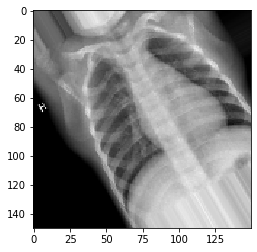

In [6]:
imshow(data_batch[0])
show()

# Modes and training

We wanted to try how pretrained model would perform on this task.<br>
We used one of keras pretrained models VGG19. The model consists of 21 filtters and maxpooling layers. The filtter amount on every layer varies. In the start the filtter amount is 64. Everytime the size of the sample is decreased by the pooling layers the amount of filtters is increased. <br> <br> The model did not include dense layers or flattening layer. So we added a flattening layer and 2 dense layers.
http://marubon-ds.blogspot.com/2017/09/vgg-fine-tuning-model.html

We chose to show the summary on this model because the model structure is not shown on the code.

In [7]:
 # Model 3
# https://keras.io/applications/
# We wanted to try a model with pretrained values. 

from keras.applications import VGG19
from keras.preprocessing import image
from keras.models import Model
from keras.layers import Dense, GlobalAveragePooling2D
from keras import backend as K


base_model = VGG19(weights='imagenet', include_top= False, input_shape=(150,150,3))

# a global spatial average pooling layer 
x = base_model.output
x = GlobalAveragePooling2D()(x)

# adding a fully-connected layer
x = Dense(512, activation='relu')(x)


predictions = Dense(1, activation='sigmoid')(x)

# this is the model we will train
model = Model(inputs=base_model.input, outputs=predictions)

model.summary() 

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 150, 150, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 150, 150, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 150, 150, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 75, 75, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 75, 75, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 75, 75, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 37, 37, 128)       0   

We chose to use almoust all the same parameters as in model 1 but we chose SGD optimizer on some parts because it was used in the example we looked at and it gave good results.


Here we select the layers which are updated, select the training values and train. Never layers first then update the VGG19 models layers.

In [10]:
import tensorflow as tf


# Define metrics
my_metrics = [tf.keras.metrics.SensitivityAtSpecificity(0.6)]





# freeze pre-trained model area's layer
for layer in base_model.layers:
    layer.trainable = False

# update the weight that are added
model.compile(optimizer='rmsprop', loss='binary_crossentropy')
model.fit(train_generator, steps_per_epoch = 20,
    verbose = 1,
    epochs = 3,
    validation_data = dev_generator,
    validation_steps = 40)

layer_num = len(model.layers)
for layer in model.layers[:21]:
    layer.trainable = False

for layer in model.layers[21:]:
    layer.trainable = True
# training
#model.compile(
  ##  optimizer = optimizers.RMSprop(learning_rate=0.001, rho=0.9),
   # loss='binary_crossentropy',
   # metrics = my_metrics)
model.compile(optimizer=SGD(lr=0.01, momentum=0.9), loss='binary_crossentropy', metrics= my_metrics)
#history = model.fit(train_generator, epochs=2, shuffle=True)

E = 7 # Number of epochs

# Train the model
print('Training ...', end='')
history = model.fit_generator(
    train_generator,
    steps_per_epoch = 20,
    verbose = 1,
    epochs = E,
    validation_data = dev_generator,
    validation_steps = 40)


Epoch 1/3
20/20 [==============================] - 414s 21s/step - loss: 0.4020 - val_loss: 0.0895
Epoch 2/3
20/20 [==============================] - 433s 22s/step - loss: 0.3318 - val_loss: 0.6743
Epoch 3/3
20/20 [==============================] - 427s 21s/step - loss: 0.3120 - val_loss: 0.5411
Training ...Epoch 1/7
20/20 [==============================] - 432s 22s/step - loss: 0.2978 - sensitivity_at_specificity_2: 0.9478 - val_loss: 0.1089 - val_sensitivity_at_specificity_2: 0.9667
Epoch 2/7
20/20 [==============================] - 423s 21s/step - loss: 0.3148 - sensitivity_at_specificity_2: 0.9504 - val_loss: 0.4738 - val_sensitivity_at_specificity_2: 0.9372
Epoch 3/7
20/20 [==============================] - 474s 24s/step - loss: 0.2859 - sensitivity_at_specificity_2: 0.9405 - val_loss: 0.1958 - val_sensitivity_at_specificity_2: 0.9436
Epoch 4/7
20/20 [==============================] - 419s 21s/step - loss: 0.2749 - sensitivity_at_specificity_2: 0.9468 - val_loss: 0.4100 - val_sens

# Results and Discussion

The following results were achieved ...

We defined the labels from the training and then tested how the model predicted the outcomes

In [11]:
labels3 = dev_generator.classes # Outputs from training
predicted3 = model.predict_generator(dev_generator).flatten()  # Predicted values

We plotted the ROC curve to determine the right threshold for predicting the outcomes

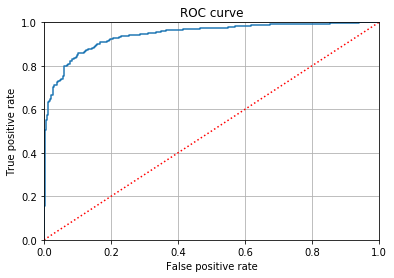

In [12]:
# Calculate ROC curve
fpr, tpr, thresholds = roc_curve(labels3, predicted3, pos_label = 1)

# Plot ROC curve
plot(fpr, tpr)
plot([0, 1], [0, 1], 'r:')
xlabel('False positive rate')
ylabel('True positive rate')
title('ROC curve')
xlim([0, 1])
ylim([0, 1])
grid()

We printed a confusion matrix from our results to see how many false negatives,false positives, true negatives and true positives did our model produce.

In [13]:
# Confusion matrix
print('Confusion matrix (machine learning way):')
cm = confusion_matrix(labels3, predicted3 > 0.5)
print(cm)
tn, fp, fn, tp = confusion_matrix(labels3, predicted3 > 0.5).ravel()
print('Confusion matrix (medicine way):')
print(array([[tp, fn], [fp, tn]]))

Confusion matrix (machine learning way):
[[309   8]
 [261 594]]
Confusion matrix (medicine way):
[[594 261]
 [  8 309]]


We printed a classification report from the results to see how well did the model predict if the patient had pneumonia or not.

In [14]:
# Classification report
cr = classification_report(labels3, predicted3 > 0.5, target_names = ['Normal (0)', 'Pneumonia (1)'])
print(cr)

               precision    recall  f1-score   support

   Normal (0)       0.54      0.97      0.70       317
Pneumonia (1)       0.99      0.69      0.82       855

     accuracy                           0.77      1172
    macro avg       0.76      0.83      0.76      1172
 weighted avg       0.87      0.77      0.78      1172



We plotted a threshold analysis to see what is the best threshold for the model to decide if the patient has pneumonia or not.

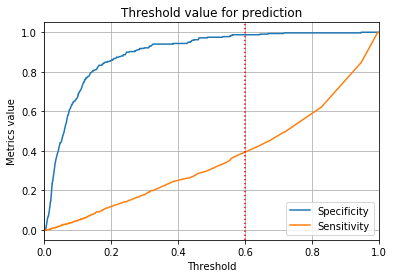

In [15]:
# Threhold analysis
plot(thresholds, 1 -fpr, label = 'Specificity')
plot(thresholds, 1 -tpr, label = 'Sensitivity')
axvline(0.6, color = 'red', linestyle = ':')
xlim([0, 1])
title('Threshold value for prediction')
xlabel('Threshold')
ylabel('Metrics value')
legend()
grid()

We loaded the best weights used in training and then compiled the model again to be used for validation to see how well the model predicts the outcomes using data it hasn't seen before.

In [16]:
# Compile model again

model.compile(optimizer=SGD(lr=0.01, momentum=0.9), loss='binary_crossentropy', metrics= my_metrics)

In [17]:
labels3 = test_generator.classes # Outputs from training
predicted3 = model.predict_generator(test_generator).flatten()  # Predicted values using validation data

Finally, we calculated all the statistics from the results we got using test data.

In [18]:
# Confusion matrix from validation
print('Confusion matrix (machine learning way):')
cm = confusion_matrix(labels3, predicted3 > 0.5)
print(cm)
tn, fp, fn, tp = confusion_matrix(labels3, predicted3 > 0.5).ravel()
print('Confusion matrix (medicine way):')
print(array([[tp, fn], [fp, tn]]))

Confusion matrix (machine learning way):
[[150 167]
 [401 453]]
Confusion matrix (medicine way):
[[453 401]
 [167 150]]


In [19]:
# Classification report from validation
cr = classification_report(labels3, predicted3 > 0.5, target_names = ['Normal (0)', 'Pneumonia (1)'])
print(cr)

               precision    recall  f1-score   support

   Normal (0)       0.27      0.47      0.35       317
Pneumonia (1)       0.73      0.53      0.61       854

     accuracy                           0.51      1171
    macro avg       0.50      0.50      0.48      1171
 weighted avg       0.61      0.51      0.54      1171



# Conclusions

To summarize we found out that this model was not so efficient in solving this problem.
20 million parameter model makes the training a long process. 
By adding layers to the pretrained model possibly affected it negatively.
While training the model did not show significant improvement.
The results in testing were significantly worse because the model was trained with augmended images and got used to them. 
Without the augmentation the result were better.
In this run we tried to train the model longer and got the worst outcome. At best this model could achive 80% accuracy. 

The final conclusion of the 3 models in on a separative notebook.